# Inflow Estimation Using Kalman Filter

In [39]:
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [40]:
SRCdata = "pump_station_data"

df = pd.read_pickle(f'data/{SRCdata}_filtered_outliers_kf.pkl')
#df = pd.read_pickle(f'data/{SRCdata}_filtered.pkl')


In [41]:
COLS = ['height', 'outflow']
df = df[COLS]

In [42]:

t = 1
area = 18
initial_Qin = df.loc[df.index[0], 'outflow']
initial_Qout = df.loc[df.index[0], "outflow"]
initial_h = df.loc[df.index[0], "height"]

# Process / Estimation Errors
error_est_Qin = 0.01
error_est_h = 0.01
error_est_Qout = 0.01

error_obs_h = 0.001
error_obs_Qout = 0.001

# Define the state transition matrix (A)
A = np.array([[1, 0, 0], [t/area, 1, -t/area], [0, 0, 1]])

# Create a Kalman Filter instance, where dim_x is the state dimension, dim_z is the measurement dimension
kf = KalmanFilter(dim_x=3, dim_z=2) 

# Initialize the state (x) and covariance (P) matrices
kf.x = np.array([initial_Qin, initial_h, initial_Qout]) # Initial state
#kf.P *= 2 # Initial covariance, you can customize this

# Define the state transition (F) and observation (H) matrices
kf.F = A
kf.H = np.array([[0, 1, 0], [0, 0, 1]]) # Assuming you are observing h and Qout

In [43]:
# Store estimates
estimates = []

# Initialize tqdm with the total number of iterations (total rows in df)
progress_bar = tqdm(total=len(df), desc="Processing")

for index, row in df.iterrows():
    kf.predict()
    measurement = np.array([row['height'], row['outflow']])
    kf.update(measurement)
    estimates.append(kf.x.copy())
    progress_bar.update(1)  # Update the progress bar

progress_bar.close()  # Close the progress bar when done
estimates = np.array(estimates)


Processing: 100%|██████████| 147998/147998 [00:09<00:00, 16164.28it/s]


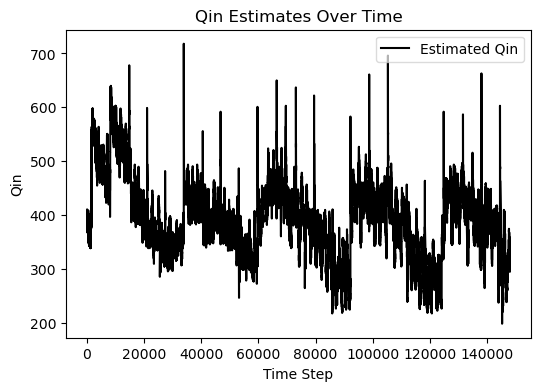

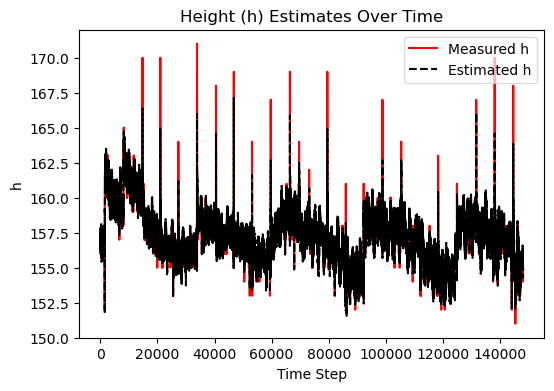

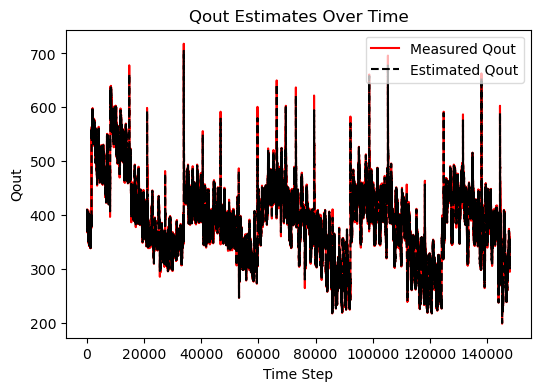

In [44]:
# Assuming your 'estimates' and 'df' are properly defined

# Convert estimates to a numpy array for easier manipulation
estimates = np.array(estimates)

# Time steps for x-axis
time_steps = range(len(estimates))

fig_size = (6, 4)

# Plot for Qin
plt.figure(figsize=fig_size)
plt.plot(time_steps, df["outflow"], label='Estimated Qin', color="black", linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Qin')
plt.title('Qin Estimates Over Time')
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()

# Plot for h
plt.figure(figsize=fig_size)
plt.plot(time_steps, df["height"], label='Measured h', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 1], label='Estimated h', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('h')
plt.title('Height (h) Estimates Over Time')
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()

# Plot for Qout
plt.figure(figsize=fig_size)
plt.plot(time_steps, df["outflow"], label='Measured Qout', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 2], label='Estimated Qout', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Qout')
plt.title('Qout Estimates Over Time')
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()


### Note: How to compare two data distributions? 

Often used, the Kullback-Leibler Divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. It's often used in statistics to measure the difference between two probability distributions.

In this example, the outflow and the height estimated with the Kalman filter adhere very well to the ground-truth distribution.
Although the height and the outflow are observable and measurable states, we estimate these two states in order to prove the validity of the estimation of the inflow. 

Let's now use the Kullback-Leibler Divergence to prove that the Outflow estimation using the Kalman filter fits well the real data distribution.


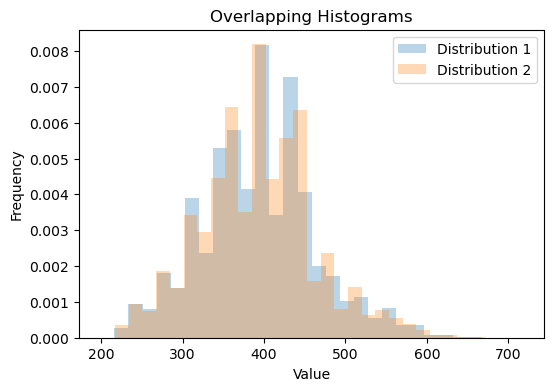

The KL Divergence is: 0.0247


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Generating two sample distributions
data1 = df["outflow"]  # Normal distribution 1
data2 = estimates[:, 2]

# Creating histograms for the distributions
count1, bins1 = np.histogram(data1, bins=30, density=True)
count2, bins2 = np.histogram(data2, bins=30, density=True)

# Calculating the bin centers from the bin edges
bin_centers1 = (bins1[1:] + bins1[:-1]) / 2
bin_centers2 = (bins2[1:] + bins2[:-1]) / 2

# Plotting the histograms
plt.figure(figsize=(6, 4))
plt.hist(data1, bins=30, alpha=0.3, label='Distribution 1', density=True)
plt.hist(data2, bins=30, alpha=0.3, label='Distribution 2', density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms')
plt.legend()

# Calculating Kullback-Leibler Divergence


plt.show()
kl_divergence = entropy(count1, count2)
print(f"The KL Divergence is: {kl_divergence:.4f}")




In this example, the pumps follow an operation strategy called "lead and drag", e.g. one pump is "leading"/operating and the other(s) are off. After a fixed period of time, the other pump is switched on. This generates a period of time where the outflow is zero. As the Kalman filter is built on the Height and Outflow measurements, the inflow estimation is affected by these outliers. 

These drops have physical meaning for the outflow, as no outflow means that the pumps are switched off. However, there is no meaning for the Inflow, as it is a continuous stochastic variable, that is not affected by the activity of the pumps. Therefore, we can apply one of the techniques to remove the outliers and re-estimate the Inflow. 